Processed vectors for p2 - Story1
Processed vectors for p2 - Story4
Processed vectors for p2 - Story5
Processed vectors for p2 - Story9
Processed vectors for p3 - Story1
Processed vectors for p4 - Story1
Processed vectors for p3 - Story4
Processed vectors for p4 - Story4
Processed vectors for p3 - Story5
Processed vectors for p4 - Story5
Processed vectors for p3 - Story9
Processed vectors for p4 - Story9


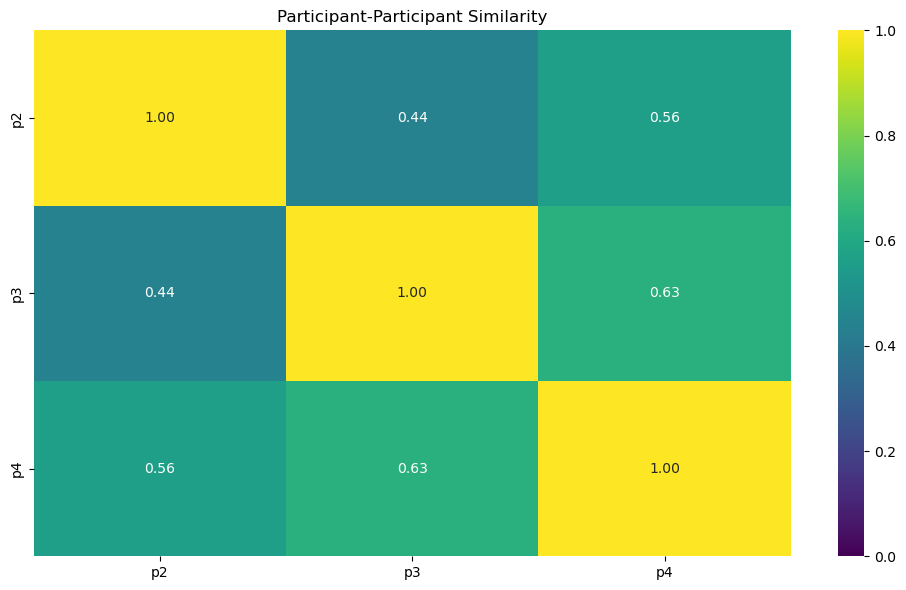

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from input_processing import vectorize, compare_vectors
import os

os.makedirs('results/figures/', exist_ok=True)

# Load embeddings
with open('embeddings.pkl', 'rb') as f:
    save_data = pickle.load(f)
    audio_embeddings = save_data['audio']
    semantic_embeddings = save_data['semantic']

# Process data
performance_vectors = vectorize(audio_embeddings, semantic_embeddings)
comparative_data = compare_vectors(performance_vectors)

# Create DataFrame
df = pd.DataFrame(comparative_data)

# Get all unique participant IDs
all_participants = sorted(set(df['participant1_id'].unique()) | set(df['participant2_id'].unique()))

# Create empty symmetric matrix with all participants
pivot_table = pd.DataFrame(
    index=all_participants,
    columns=all_participants,
    dtype=float
)

# Fill the matrix with values
for _, row in df.iterrows():
    p1 = row['participant1_id']
    p2 = row['participant2_id']
    sim = row['vector_similarity']
    pivot_table.loc[p1, p2] = sim
    pivot_table.loc[p2, p1] = sim  # Make it symmetric

# Set diagonal to 1.0
for participant in all_participants:
    pivot_table.loc[participant, participant] = 1.0

# Create heatmap with modified parameters
plt.figure(figsize=(10, 6))  # Increase figure size
sns.heatmap(pivot_table,
            annot=True,           # Show all numbers
            fmt='.2f',            # Format to 2 decimal places
            cmap='viridis',      # Color scheme
            vmin=0.0,            # Set minimum value for color scale
            vmax=1.0,             # Set maximum value for color scale
            annot_kws={'size': 10}  # Increase font size for annotations
)
plt.title('Participant-Participant Similarity')
plt.tight_layout()  # Adjust layout to ensure all elements are visible
plt.savefig('results/figures/participant-participant_similarity.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

/tmp/ipykernel_3437439/1448998008.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_embedding = torch.tensor(p_data['retelling_semantic'])


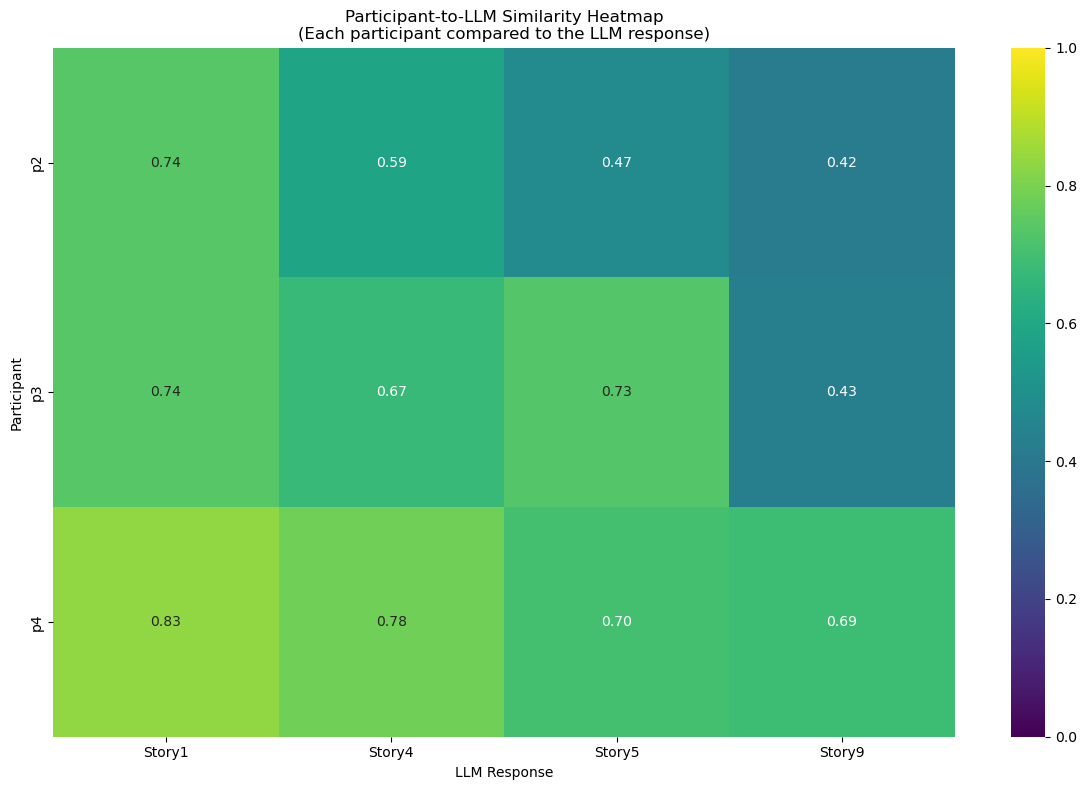

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
import os

os.makedirs('results/figures/', exist_ok=True)

# Load both embedding sets
with open('embeddings.pkl', 'rb') as f:
    participant_data = pickle.load(f)
    participant_embeddings = participant_data['semantic']

with open('llm_embeddings.pkl', 'rb') as f:
    llm_embeddings = pickle.load(f)

def plot_llm_to_participant_similarities():
    similarities = []
    
    # Get all unique story IDs
    story_ids = sorted(set(data['story_id'] for data in participant_embeddings.values()))
    
    for story_id in story_ids:
        # Get all participant embeddings for this story
        participant_story_embeddings = {
            k: v for k, v in participant_embeddings.items() 
            if v['story_id'] == story_id
        }
        
        # Compare each participant's embedding with their corresponding LLM embedding
        for p_key, p_data in participant_story_embeddings.items():
            participant_id = p_data['participant_id']
            
            # Get corresponding LLM embedding
            llm_key = f"{participant_id}-{story_id}"
            if llm_key in llm_embeddings:
                p_embedding = torch.tensor(p_data['retelling_semantic'])
                llm_embedding = torch.tensor(llm_embeddings[llm_key]['retelling_semantic'])
                
                similarity = torch.nn.functional.cosine_similarity(
                    p_embedding.unsqueeze(0),
                    llm_embedding.unsqueeze(0)
                ).item()
                
                similarities.append({
                    'participant_id': participant_id,
                    'story_id': story_id,
                    'similarity': similarity
                })
    
    # Create DataFrame and plot heatmaps by story
    df = pd.DataFrame(similarities)
    
    # Create one heatmap showing all stories and participants
    plt.figure(figsize=(12, 8))
    pivot_table = df.pivot(
        index='participant_id',
        columns='story_id',
        values='similarity'
    )
    
    sns.heatmap(pivot_table, 
                annot=True, 
                cmap='viridis',
                vmin=0, 
                vmax=1,
                center=0.5,
                fmt='.2f')
    plt.title('Participant-to-LLM Similarity Heatmap\n(Each participant compared to the LLM response)')
    plt.xlabel('LLM Response')
    plt.ylabel('Participant')
    plt.tight_layout()
    plt.savefig('results/figures/participant-llm_similarity.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

# Generate and plot the heatmap
plot_llm_to_participant_similarities()